In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 5)

import warnings
warnings.filterwarnings('ignore')

# Boostings

Данные с которыми вы будете работать представляют из себя характеристики клиента страховой компании по которым нужно понять будет ли он заинтересован в страховке. Таким образом, страховая компания может более оптимально таргетить рекламу и выстраивать коммуникацию с клиентами, повышая конверсию.

**Описания колонок:**
- Gender - Male, Female
- Age - Возраст
- Driving_License - Наличие водительского удостоверения
- Region_Code - Область проживания
- Previously_Insured - Пользовался ли раньше услугами страховой компании
- Vehicle_Age - Возраст транспортного средства
- Vehicle_Damage - Попадало ли траспортное средство в ДТП
- Annual_Premium - Ежегодные выплаты клиента
- Policy_Sales_Channel - Политика распространения страховых услуг (через посредников, напрямую и т.д.)
- Vintage - Количество дней, в течение которых клиент был связан с компанией 


- **Response** - заинтересован в страховке 1, не откликнулся 0

In [3]:
data = pd.read_csv('vehicle_insurance.csv')

data

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,Female,24,1,37.0,1,< 1 Year,No,21243.0,152.0,21,0
9996,Male,28,1,35.0,1,< 1 Year,No,23589.0,160.0,173,0
9997,Female,27,1,15.0,0,< 1 Year,Yes,33340.0,152.0,207,0
9998,Female,28,1,14.0,1,< 1 Year,No,25426.0,152.0,247,0


**Задание 0.** Проведите небольшой EDA. Посмотрите на распределения некоторых колонок, на матрицу корреляций. Также проверьте баланс классов и посмотрите на распределение возраста транспортного средства в зависимости от response. \
Закодируйте признаки типа `object` с помощью `one-hot` кодирования.

P.S. некоторые не `object`колонки по смыслу очевидно являются категориальными. Так как мы будем строить ансамбли на основе деревьев, их можно оставить в первоначальном виде.

In [6]:
categorical_col = list(data.loc[:, data.dtypes == object].columns)
num_col = [col for col in data.columns if col not in categorical_col]
one_hot = pd.get_dummies(data[categorical_col], prefix=categorical_col, drop_first=True)
data = pd.concat((data.drop(categorical_col, axis=1), one_hot), axis=1)
data.head()



ValueError: No objects to concatenate

**Задание 1.** Обучите градиентный бустинг из sklearn на данных и замерьте accuracy и f1-score на тестовой выборке. В качестве параметров ансамбля установите `learning_rate = 1`, `random_state = 1`, `n_estimators = 100`. Изобразите ROC-кривую и посчитайте AUC, оцените качество классификации. (2б)

P.S. для всех прочих моделей в этом домашнем задании тоже фиксируйте `random_state = 1`. Как думаете, что может быть случайного в процедуре обучения градиентного бустинга?

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(learning_rate=1,
                                   random_state=1,
                                   n_estimators=100)
model.fit(X_train, y_train)
print(f'Accuracy на трейне: {model.score(X_train, y_train):.3f}')
print(f'Accuracy на тесте: {model.score(X_test, y_test):.3f}')


Accuracy на трейне: 0.927
Accuracy на тесте: 0.852


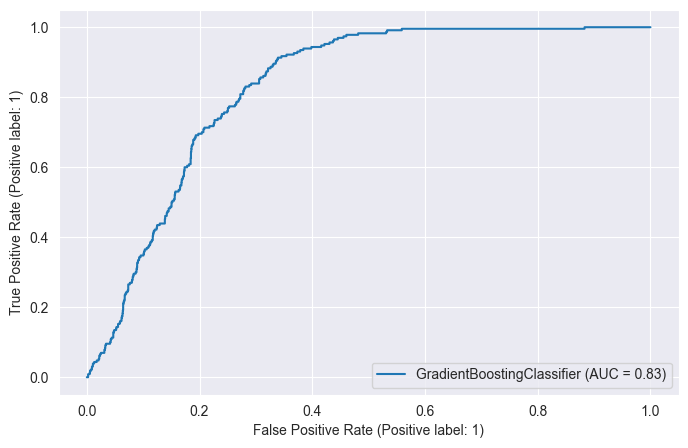

In [9]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, X_test, y_test)

In [10]:
fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
auc(fpr, tpr)

0.828168754605748

**Задание 2.** Переберите параметры `n_estimators` и `learning_rate` по двумерной сетке. При обучении в цикле сразу считайте f1-score на тестовой выборке и сохраняйте результат в матрицу. Для какого алгоритма качество окажется максимальным?

Постройте кривые для метрики f1-score в зависимости от числа шагов для нескольких learning_rate. Изобразите heatmap полученной матрицы. Сделайте вывод, как количество шагов влияет на качество совместно с различной скоростью обучения? (2б)

P.S. для подсчета f1-score передайте в функцию параметр `average='weighted'`, чтобы учитывался еще и баланс классов (вспомните микро/макро-усреднения).

In [11]:
### Задаем сетку параметров

n_estimators_list = [5, 10, 20, 50, 100, 200, 700, 1000]
learning_rate_list = [1, 0.1, 0.01]

In [27]:
f1_score_df = []
for i in learning_rate_list:
    for j in n_estimators_list:
        model = GradientBoostingClassifier(learning_rate=i,
                                   random_state=1,
                                   n_estimators=j)
        model.fit(X_train, y_train)
        f1_score_df.append([i, j, f1_score(y_test, model.predict(X_test), average="weighted")])


TypeError: 'float' object is not subscriptable

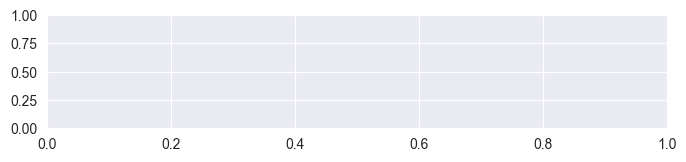

In [29]:
fig = plt.figure()
number_of_fig = 1
for i in learning_rate_list:
    ax = fig.add_subplot(3, 1, number_of_fig)
    sns.lineplot(x=learning_rate_list[i][1], y=learning_rate_list[i][2])
    plt.legend([f"learning rate ={learning_rate_list[i][0]}"])
fig.tight_layout()



<AxesSubplot: >

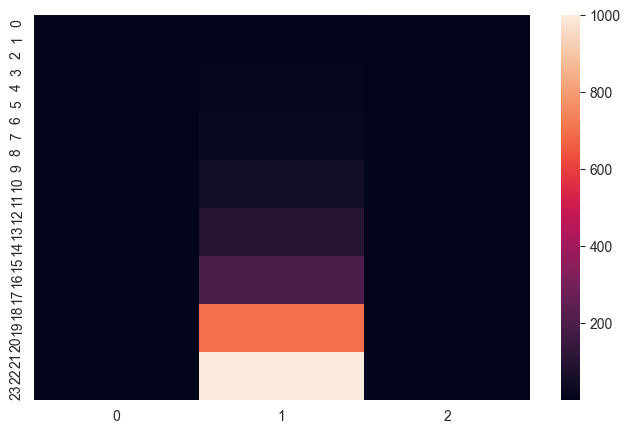

In [19]:
for i in range

**Задание 3.** Вам потребуется обучить 4 модели и посчитать метрику f1-score на тестовой и обучающей выборках для каждой модели. 
1. Случайный лес с максимальной глубиной деревьев 5,
2. Случайный лес с максимальной глубиной деревьев 5000,
3. Градиентный бустинг с максимальной глубиной деревьев 5,
4. Градиентный бустинг с максимальной глубиной деревьев 5000.

Для каждой модели перебирайте значения `n_estimators`, как в предыдущем задании. Отрисуйте графики зависимости f1-score от количества шагов, используя `average='weighted'` для учёта баланса классов. 

Если в качестве базовой модели брать неглубокие деревья, то какая модель лучше запоминает обучающую выборку: случайный лес или градиентный бустинг? Какая из них лучше предсказывает на тестовой выборке? Как изменятся ответы, если базовая модель - это глубокое решающее дерево?

Подвержен ли переобучению случайный лес и градиентный бустинг? Как это отражается на графиках? (4б)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

n_estimators_list = [2, 3, 4, 5, 10, 20, 50, 70, 100, 200, 700, 1000, 2000]

### Your code is here

**Задание 4.** Установите библиотеку `catboost`. Главной особенностью catboost явялется наличие встроенной обработки категориальных признаков. Для каждого категориального столбца вычисляется следующее значение
$$
avg\_target = \dfrac{countInClass + prior}{totalCount + 1},
$$
* countInClass - количество объектов положительного класса для данной категории **до текущего объекта**,
* prior - некоторая константа для числителя, обычно равна доле положительного класса в таргете,
* totalCount - количество наблюдаемых категорий вплоть **до текущего** с той же категорией, что и у текущего.

Так как первые такие значения будут иметь больший разброс, чем последние, то выборку перемешивают несколько раз и полученные статистики усредняют. 
В отличие от target encoder подсчитанные значения зависят от наблюдаемой истории, т.е. вычисляются только из наблюдений до них, таким образом не происходит target leakage. 

Почитать подробнее можно здесь: [Transforming categorical features](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)

Обучите CatBoostClassifier с дефолтными параметрами. Используйте датасет до  (разбейте на train/test по старой логике с тем же random state'ом). Категориальные колонки передайте в параметр `cat_features` метода `fit`. Catboost сам с ними разберется.

Сравните качество с моделью из предыдущего задания. Стало ли лучше?

Сравните feature importances в модели из задания 2 и в catboost с помощью соответствующих методов, изобразите их, используя `barplot`. \
Какие признаки стали более важными с новым методом кодирования? (4б)

In [ ]:
from catboost import CatBoostClassifier

### Your code is here



**Задание 5.** Установите библиотеку `lightgbm`. На сегодняшний день это наиболее быстрый метод градиентного бустинга, при этом расходующий небольшое количество оперативной памяти. Достигает он этого за счет построения деревьев вглубь по листьям (leaf-wise), а не по уровням (level-wise), как другие методы, например XGBoost. 
Более понятно это на картинке:

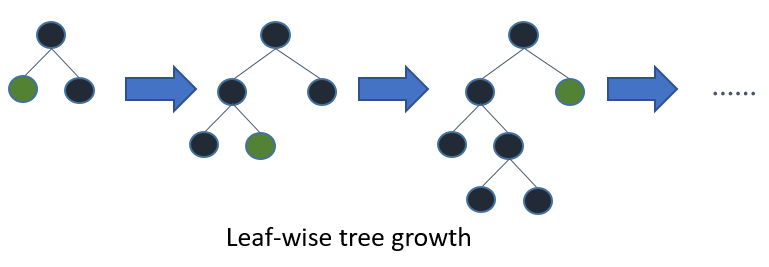

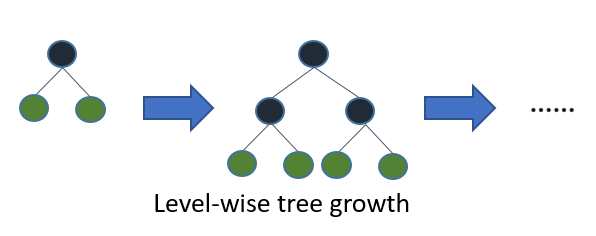

В то время, как XGBoost за раз разделяет вершины на целом уровне той же глубины, LightGBM разделяет одну вершину за раз. Отсюда прирост в скорости.

Обучите `LGBMClassifier` на изначальных(закодированных) данных и добейтесь максимального качества на тестовой выборке, перебрав параметры глубины деревьев, количества шагов, скорости обучения и т.д.

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [100, 500, 1000, 2000],
          'max_depth': [2, 3, 5, 100],
          'learning_rate': [0.1, 0.01, 0.001]}

### Your code is here


